In [2]:
import carla
import random

# Connect to the client and retrieve the world object
client = carla.Client('localhost', 2000)
world = client.get_world()


In [3]:
client.load_world('Town01')

RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [3]:
vehicle_blueprints = world.get_blueprint_liwbrary().filter('*vehicle*')

In [4]:
vehicle_blueprints

In [5]:
spawn_points = world.get_map().get_spawn_points()
random.seed(5151)
vm = random.choice(vehicle_blueprints)
sp = random.choice(spawn_points)
print(sp)

Transform(Location(x=339.295776, y=45.078133, z=0.300000), Rotation(pitch=0.000000, yaw=-89.999992, roll=0.000000))


In [6]:
world.try_spawn_actor(vm,sp)

In [7]:
sp_copy = sp
cam = world.get_spectator()

sp_copy.location.z += 5
sp_copy.rotation.pitch += -45
print(sp_copy.rotation)
cam.set_transform(sp_copy)

Rotation(pitch=-45.000000, yaw=-89.999992, roll=0.000000)


In [8]:
random.seed(51)
vm = random.choice(vehicle_blueprints)
sp = random.choice(spawn_points)
mycar = world.try_spawn_actor(vm,sp)
sp_copy = sp
cam = world.get_spectator()

sp_copy.location.z += 5
sp_copy.rotation.pitch += -45
print(sp_copy.rotation)
cam.set_transform(sp_copy)

Rotation(pitch=-45.000000, yaw=-90.000404, roll=0.000000)


In [10]:
camera_init_tf = carla.Transform(carla.Location(z=1.5))
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera = world.spawn_actor(camera_bp, camera_init_tf, attach_to=mycar)

In [11]:
print(camera_init_tf)


Transform(Location(x=0.000000, y=0.000000, z=1.500000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))


In [9]:
print(world.get_weather())

WeatherParameters(cloudiness=60.000000, precipitation=40.000000, precipitation_deposits=40.000000, wind_intensity=30.000000, sun_azimuth_angle=275.000000, sun_altitude_angle=20.000000, fog_density=5.000000, fog_distance=0.750000, fog_falloff=0.100000, wetness=80.000000, scattering_intensity=1.000000, mie_scattering_scale=0.030000, rayleigh_scattering_scale=0.033100, dust_storm=0.000000)


In [12]:
settings = world.get_settings()
settings.synchronous_mode = True # Enables synchronous mode
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)

157509

### This following block, is a good demonstration of having the sensor in a loop, wait for getting the sensor info, and proceed to the next step. 

In [14]:
import queue, numpy, cv2
import matplotlib.pyplot as plt
image_queue = queue.Queue()
camera.listen(image_queue.put)

while True:
    world.tick()
    image = image_queue.get()
    img = numpy.reshape(numpy.copy(image.raw_data), (image.height, image.width, 4))
    cv2.namedWindow('ImageWindowName', cv2.WINDOW_AUTOSIZE)
    cv2.imshow('ImageWindowName',img)
    cv2.waitKey(1)

KeyboardInterrupt: 

In [ ]:
import queue, numpy, cv2
lidar_init_tf = carla.Transform(carla.Location(z=3))
lidar_queue = queue.Queue()
lidar_bp = world.get_blueprint_library().find('sensor.lidar.ray_cast')
lidar = world.spawn_actor(lidar_bp, lidar_init_tf, attach_to=mycar)
lidar.listen(lidar_queue.put)


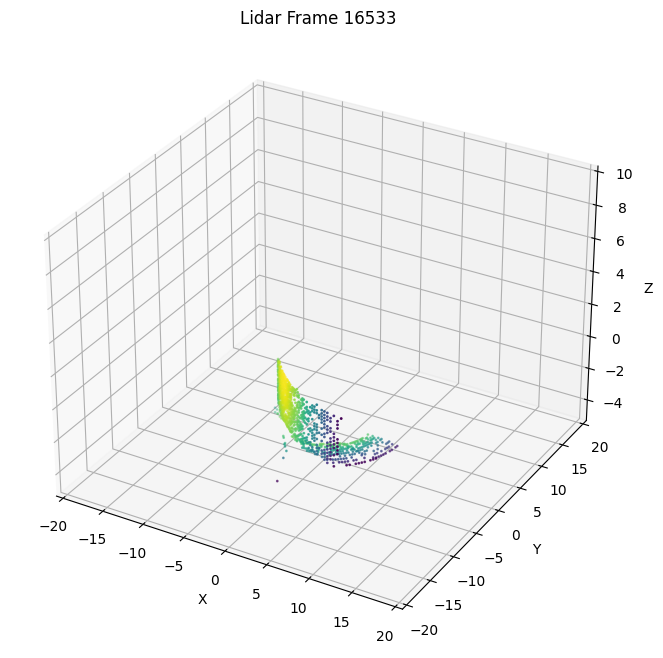

Received 563 LiDAR points.


In [ ]:
while True:
    world.tick()
    ray = lidar_queue.get()
    points = numpy.frombuffer(ray.raw_data, dtype=numpy.float32).reshape(-1, 4)

    # Now 'points' is a NumPy array containing your LiDAR point cloud
    # You can access individual components like:
    # x_coords = points[:, 0]
    # y_coords = points[:, 1]
    # z_coords = points[:, 2]
    # intensities = points[:, 3]

    # Further processing or visualization can be done here
    print(f"Received {len(points)} LiDAR points.")
    update_plot(points,ray.frame_number)
    #break

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output
import time

# --- Setup the Figure and Axis outside the loop ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Set initial axis limits for consistency
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_zlim([-5, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.close(fig) # Prevent a static display of the empty figure initially

def update_plot(point_cloud_data, frame_number):
    """
    Updates the existing plot with new point cloud data.
    
    Args:
        point_cloud_data (np.array): A NumPy array of shape (-1, 4) or (-1, 3) 
                                     containing the [X, Y, Z, Intensity] points.
        frame_number (int): The current frame number to update the title.
    """
    # 1. Clear the previous points from the axis
    ax.cla() 

    # 2. Re-set the axis limits (clearing resets them to default)
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-5, 10])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Lidar Frame {frame_number}')

    # 3. Plot the new data
    x = point_cloud_data[:, 0]
    y = point_cloud_data[:, 1]
    z = point_cloud_data[:, 2]
    # Use intensity for color if available, otherwise default
    colors = point_cloud_data[:, 3] if point_cloud_data.shape[1] == 4 else 'c'
    
    ax.scatter(x, y, z, s=1, c=colors, cmap='viridis')

    # 4. Clear the previous notebook output and display the new figure
    clear_output(wait=True) # `wait=True` ensures smooth transition
    display(fig)


In [47]:
debug = world.debug
lidar_transform = lidar.get_transform()
debug.draw_box(
    box=carla.BoundingBox(lidar_transform.location, carla.Vector3D(0.5, 0.5, 0.5)),
    rotation=lidar_transform.rotation,
    life_time=10000,  # Draw for a short duration
    thickness=1,
    color=carla.Color(r=255, g=0, b=0) # Red color
)